# Implementation of a fusion gate on Perceval

In [2]:
import perceval as pcvl
import perceval.components.unitary_components as comp
import numpy as np
import math
import sympy as sp
import random as rand
import matplotlib.pyplot as plt

## Creating a linear cluster state
To create a linear cluster state mathematically, we use recursivity

In [3]:
def cluster_state_pseudo(n):
    if n==2 :
        return [[1,"00"],[1,"01"],[1,"10"],[-1,"11"]]
    cs,cs1=cluster_state_pseudo(n-1),cluster_state_pseudo(n-1)
    
    L=cs+cs1
    #print(L)
    for i in range(2**(n-1)):
        L[i][1]+="0"
    for i in range(2**(n-1),2**n):
        if L[i][1][-1]=="1":
            L[i][0]*=-1
        L[i][1]+="1"
    return L

def cluster_state(n): # n>=2
    if n==0:
        return 1
    if n==1:
        return pcvl.StateVector([1])
    s=1/np.sqrt(2)**n
    h=pcvl.StateVector([1,0])
    v=pcvl.StateVector([0,1])
    L=cluster_state_pseudo(n)
    c_state=h**n
    for i in range(1,2**n):
        if L[i][1][0]=="0":
            psi=h
        else:
            psi=v
        for j in range(1,n):
            if L[i][1][j]=="0":
                psi*=h
            else: 
                psi*=v
        if L[i][0]==1:
            c_state+=psi
        else :
            c_state-=psi
    return c_state
    
#print(cluster_state_pseudo(3))
#print(cluster_state(3))

def all_state(n):
    if n==2:
        return [[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1]]
    L=all_state(n-1)+all_state(n-1)
    for i in range(2**(n-1)):
        L[i]=[1,0]+L[i]
        L[i+2**(n-1)]=[0,1]+L[i+2**(n-1)]
    return L

def all_basic_state(n):
    L=all_state(n)
    S=[]
    for i in range(len(L)):
        S.append(pcvl.BasicState(L[i]))
    return S

print(all_basic_state(3))
    

[<perceval.utils.statevector.BasicState object at 0x0000021882479F90>, <perceval.utils.statevector.BasicState object at 0x000002188247E180>, <perceval.utils.statevector.BasicState object at 0x000002188247E1D0>, <perceval.utils.statevector.BasicState object at 0x000002188247E220>, <perceval.utils.statevector.BasicState object at 0x000002188247E270>, <perceval.utils.statevector.BasicState object at 0x000002188247E2C0>, <perceval.utils.statevector.BasicState object at 0x000002188247E310>, <perceval.utils.statevector.BasicState object at 0x000002188247E360>]


Physical building of a linear cluster state of size n

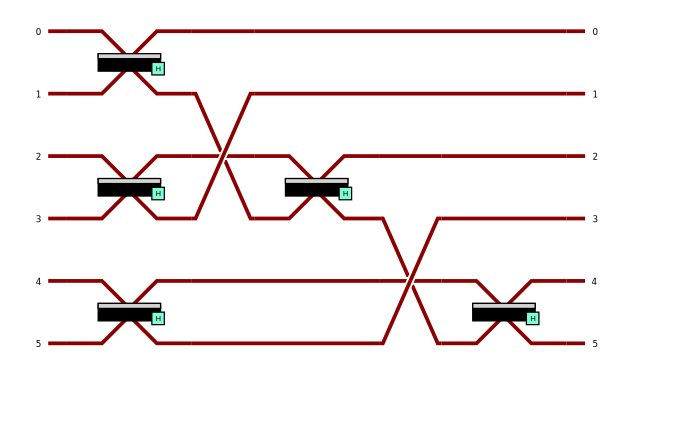

In [4]:
def cs_n_circuit(n):
    circuit=pcvl.Circuit(2*n,name='CSn')
    for i in range(0,2*n,2):
        circuit.add((i,i+1),comp.BS.H())
    for i in range(0,2*n-2,2):
        circuit.add(i,comp.PERM([0,3,2,1]))
        circuit.add((i+2,i+3),comp.BS.H())
    return circuit

pcvl.pdisplay(cs_n_circuit(3))

In [1]:
def classic_state(n):
    L=[0]*(2*n)
    for i in range(n):
        L[2*i]=1
    return L
print(classic_state(6))

def cs_n_state(n):
    circuit=cs_n_circuit(n)
    backend = pcvl.BackendFactory().get_backend("SLOS")
    simulator = backend(circuit)
    output_state=simulator.evolve(pcvl.BasicState(classic_state(n)))
    return output_state

def postprocess_condition(o,n):
    for i in range(n):
        if o[2*i]+o[2*i +1]!=1:
            return False
    return True

def cs_n_process(n):
    processor=pcvl.Processor("SLOS",cs_n_circuit(n))
    processor.set_postprocess(lambda o: postprocess_condition(o,n))
    ca=pcvl.algorithm.Analyzer(processor,[pcvl.BasicState(classic_state(n))],all_basic_state(n))
    pcvl.pdisplay(ca)
    return processor
    
cs_n_process(3)

print(cs_n_state(3))

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


NameError: name 'pcvl' is not defined

## Implementing measurement

In [6]:
def measure(state,mode):
    map_measure_state = state.measure(mode)
    n=len(map_measure_state)
    i=rand.randint(0,n-1)
    weights=[]
    for s,(p,v) in map_measure_state.items():
        weights.append(p)
    #print(weights)
    L=rand.choices([k for k in range(n)],weights)
    i=L[0]
    #print(i)
    j=0
    for s,(p,v) in map_measure_state.items():
        if j==i:
            return s,p,v
        j+=1

def measure_fusion(state,i,j):
    s,p,v=measure(state,(2*i,2*i+1,2*j,2*j+1))
    #print(s,p,v)
    if s[0]+s[1]>=2 or s[2]+s[3]>=2 :
        return "fusion has failed"
    return v

print(measure_fusion(3*pcvl.StateVector("|1,0,1,0,1,0>")-4*pcvl.StateVector("|1,0,0,1,0,1>")+5*1j*pcvl.StateVector("|0,1,0,1,1,0>")+(1-1j)*pcvl.StateVector("|0,1,1,0,1,0>"),0,1))

|1,0>


## Fusion function

### Type II gate 

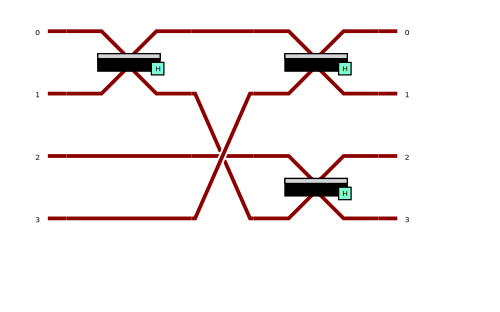

In [7]:
def typeIIcircuit():
    circuit=pcvl.Circuit(4,name="fusion gate")
    circuit. add((0,1),comp.BS.H())
    circuit. add((0,1,2,3),comp.PERM([0,3,2,1]))
    circuit. add((0,1),comp.BS.H())
    circuit. add((2,3),comp.BS.H())
    return circuit
pcvl.pdisplay(typeIIcircuit())

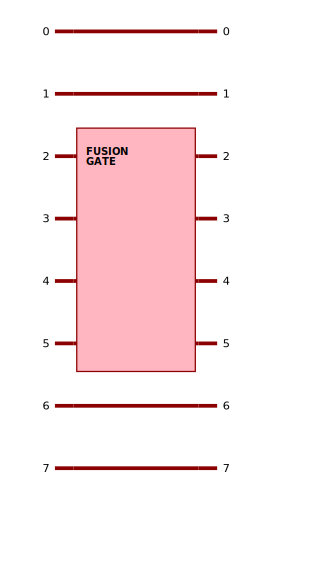

In [8]:
def typeIIgate(M,i,j): # M is number of modes i and j qbits we want to apply the fusion to
    Mi0,Mi1,Mj0,Mj1=2*i,2*i+1,2*j,2*j+1 # Modes of qbits i and j
    circuit=pcvl.Circuit(M,name="fusion gate")
    if j>i+1: # if j and i are not neighbors, make sure it is the case
        t1,L2=tuple([k for k in range(Mi1+1,Mj1+1)]),[k for k in range(Mj1-Mi1)]
        #print(t1)
        L2[0],L2[1],L2[-2],L2[-1]=L2[-2],L2[-1],L2[0],L2[1]
        #print(L2)
        circuit.add(t1,comp.PERM(L2))
    circuit. add((Mi0,Mi1,Mi1+1,Mi1+2),typeIIcircuit(),merge=False)
    if j>i+1: # put back the modes to normal
        circuit.add(t1,comp.PERM(L2))
    return circuit

pcvl.pdisplay(typeIIgate(8,1,2))

In [9]:
def fusion_gate(input_state,i,j): # 0<=i<j<=N-1
    M=input_state.m # M modes
    circuit=typeIIgate(M,i,j)
    backend = pcvl.BackendFactory().get_backend("SLOS")
    simulator = backend(circuit)
    output_state=simulator.evolve(input_state)
    #print(output_state)
    
    return measure_fusion(output_state,i,j)

N1,N2,N3=0,0,0
for n in range(100):
    s=fusion_gate(cluster_state(2)*cluster_state(2),1,2)
    if s=="fusion has failed":
        N1+=1
    #else: #print(s[3])
print(N1)



50


### Distribution outputs w/ and w/o errors

In [10]:
output_bad=[pcvl.BasicState("|1,0,0,0,2,0,1,0>"),pcvl.BasicState("|1,0,0,0,2,0,0,1>"),pcvl.BasicState("|1,0,2,0,0,0,0,1>"),pcvl.BasicState("|1,0,2,0,0,0,1,0>"),
        pcvl.BasicState("|1,0,0,2,0,0,0,1>"),pcvl.BasicState("|1,0,0,2,0,0,1,0>"),pcvl.BasicState("|1,0,0,0,0,2,1,0>"),pcvl.BasicState("|1,0,0,0,0,2,0,1>"),
        pcvl.BasicState("|0,1,0,0,0,2,0,1>"),pcvl.BasicState("|0,1,0,0,0,2,1,0>"),pcvl.BasicState("|0,1,0,0,2,0,0,1>"),pcvl.BasicState("|0,1,0,0,2,0,1,0>"),
        pcvl.BasicState("|0,1,0,2,0,0,0,1>"), pcvl.BasicState("|0,1,0,2,0,0,1,0>"),pcvl.BasicState("|0,1,2,0,0,0,0,1>"),pcvl.BasicState("|0,1,2,0,0,0,1,0>")]

output_good=[pcvl.BasicState("|1,0,1,0,1,0,1,0>"),pcvl.BasicState("|1,0,1,0,1,0,0,1>"),pcvl.BasicState("|1,0,1,0,0,1,1,0>"),pcvl.BasicState("|1,0,1,0,0,1,0,1>"),
         pcvl.BasicState("|1,0,0,1,1,0,1,0>"),pcvl.BasicState("|1,0,0,1,1,0,0,1>"),pcvl.BasicState("|1,0,0,1,0,1,1,0>"),pcvl.BasicState("|1,0,0,1,0,1,0,1>"),
         pcvl.BasicState("|0,1,1,0,1,0,1,0>"),pcvl.BasicState("|0,1,1,0,1,0,0,1>"),pcvl.BasicState("|0,1,1,0,0,1,1,0>"),pcvl.BasicState("|0,1,1,0,0,1,0,1>"),
         pcvl.BasicState("|0,1,0,1,1,0,1,0>"),pcvl.BasicState("|0,1,0,1,1,0,0,1>"),pcvl.BasicState("|0,1,0,1,0,1,1,0>"),pcvl.BasicState("|0,1,0,1,0,1,0,1>")]

def fusion_with_errors(input_state,i,j,output_states='*',brightness=1,g2=0,distinguishability='indistinguishable'):
    source = pcvl.Source(emission_probability=brightness, multiphoton_component=g2,multiphoton_model=distinguishability)
    M=input_state.m # M modes
    circuit=typeIIgate(M,i,j)
    processor = pcvl.Processor("SLOS", circuit, source)
    ca = pcvl.algorithm.Analyzer(processor, [input_state],output_states)
    ca.compute()
    pcvl.pdisplay(ca)
    #print("performance=%s, fidelity=%.3f%%" % (pcvl.simple_float(ca.performance)[1], ca.fidelity * 100))
    
fusion_with_errors(pcvl.BasicState([1,0,1,0,1,0,1,0]),1,2,output_good+output_bad,brightness=1,g2=0,distinguishability='indistinguishable')

Text(0, 0.5, 'Success probability')

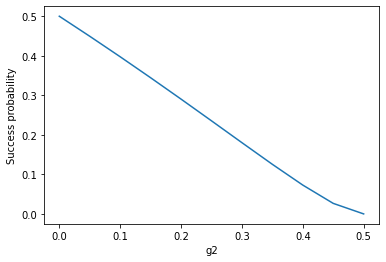

In [11]:
G=[0,0.05,0.1,0.15,.2,.25,.3,.35,.4,.45,.5]
F1=np.array([1/8,0.112344,0.09938,0.086121,0.0726,0.058875,0.045059,0.031369,0.018237,0.006664,0])*4
plt.plot(G,F1)
plt.xlabel("g2")
plt.ylabel("Success probability")

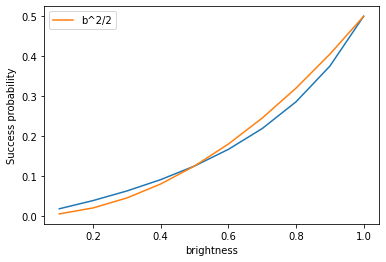

In [12]:
B=[1,0.9,0.8,0.7,.6,.5,.4,.3,.2,.1]
F2=[1/8,3/32,1/14,0.054688,1/24,1/32,1/44,0.015625,0.009615,0.004464]
B.reverse()
F2.reverse()
#print(B,F2)
F3=[4*f for f in F2]
Y=[0.5*(b**2) for b in B ]

plt.plot(B,F3)
plt.plot(B,Y,label="b^2/2")
plt.xlabel("brightness")
plt.ylabel("Success probability")
plt.legend(loc="upper left")
plt.show()

## Boosted fusion gate

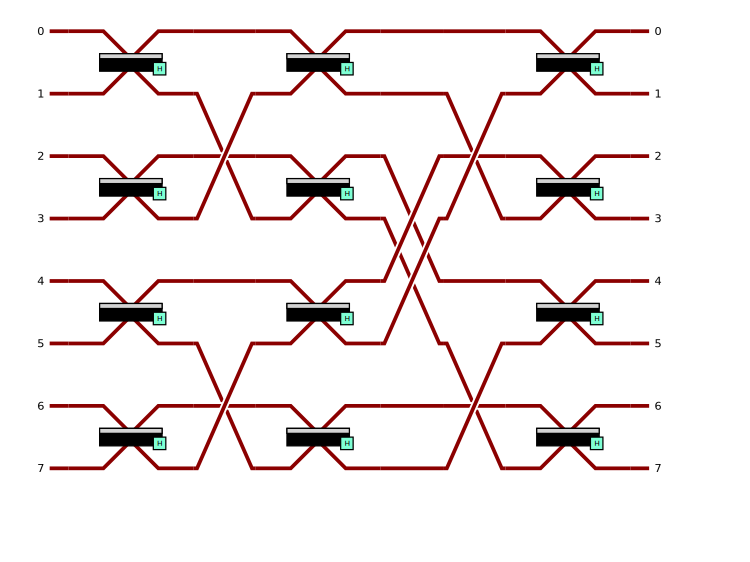

In [34]:
def bfg_bell_pair():
    circuit=pcvl.Circuit(8,name='boosted fusion gate')
    circuit.add((0,1),comp.BS.H())
    circuit.add((2,3),comp.BS.H())
    circuit.add((4,5),comp.BS.H())
    circuit.add((6,7),comp.BS.H())
    circuit.add((0,1,2,3,4,5,6,7),comp.PERM([0,3,2,1,4,7,6,5]))
    circuit.add((0,1),comp.BS.H())
    circuit.add((2,3),comp.BS.H())
    circuit.add((4,5),comp.BS.H())
    circuit.add((6,7),comp.BS.H())
    circuit.add((2,3,4,5),comp.PERM([2,3,0,1]))
    circuit.add((0,1,2,3,4,5,6,7),comp.PERM([0,3,2,1,4,7,6,5]))
    circuit.add((0,1),comp.BS.H())
    circuit.add((2,3),comp.BS.H())
    circuit.add((4,5),comp.BS.H())
    circuit.add((6,7),comp.BS.H())
    return circuit

pcvl.pdisplay(bfg_bell_pair())

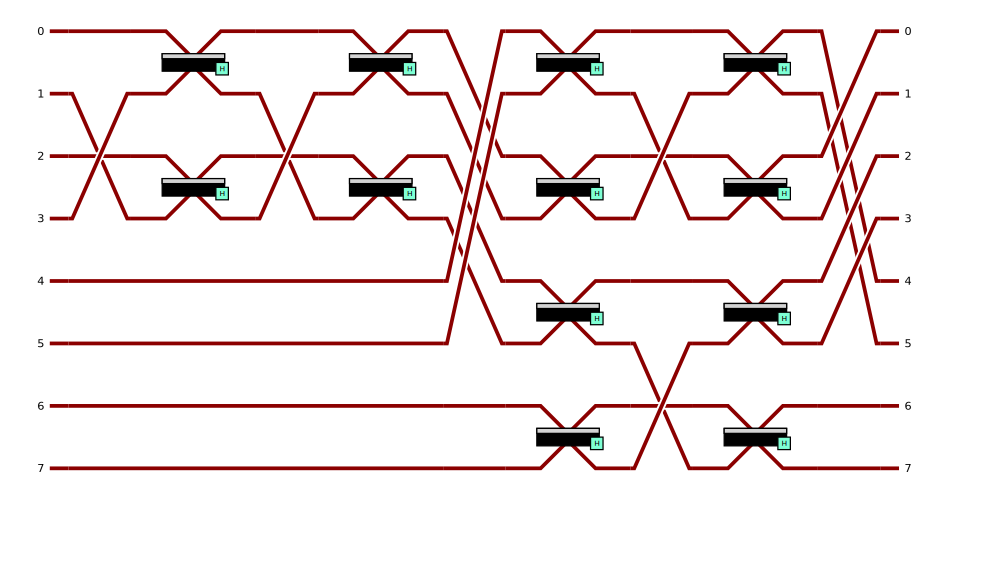

In [35]:
def bfg_ancillary():
    circuit=pcvl.Circuit(8,name='boosted fusion gate ancillary')
    circuit.add(0,comp.PERM([0,3,2,1]))
    circuit.add(0,comp.BS.H())
    circuit.add(2,comp.BS.H())
    circuit.add(0,comp.PERM([0,3,2,1]))
    circuit.add(0,comp.BS.H())
    circuit.add(2,comp.BS.H())
    circuit.add(0,comp.PERM([2,3,4,5,0,1,6,7]))
    circuit.add(0,comp.BS.H())
    circuit.add(2,comp.BS.H())
    circuit.add(4,comp.BS.H())
    circuit.add(6,comp.BS.H())
    circuit.add(0,comp.PERM([0,3,2,1]))
    circuit.add(4,comp.PERM([0,3,2,1]))
    circuit.add(0,comp.BS.H())
    circuit.add(2,comp.BS.H())
    circuit.add(4,comp.BS.H())
    circuit.add(6,comp.BS.H())
    circuit.add(0,comp.PERM([4,5,0,1,2,3,6,7]))
    return circuit

pcvl.pdisplay(bfg_ancillary())

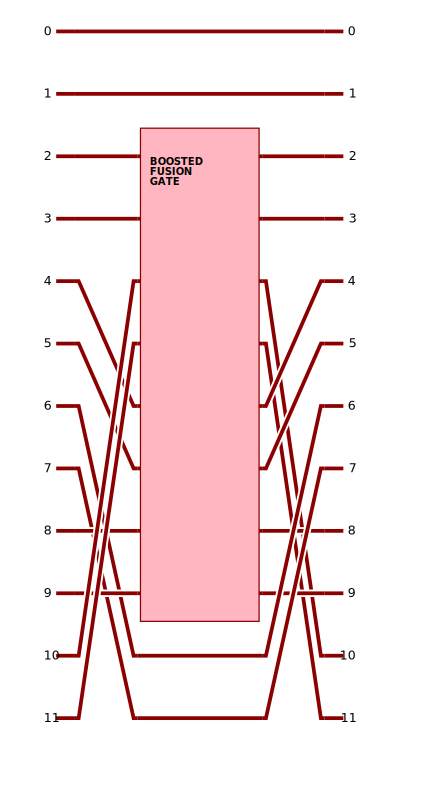

In [36]:
def boosted_fusion_gate_circuit(input_state,i,j,fusion_circuit):
    M,N=input_state.m +4,input_state.n[0]
    Mi0,Mi1,Mj0,Mj1=2*i,2*i+1,2*j,2*j+1 # Modes of qbits i and j
    circuit=pcvl.Circuit(M,name='boosted fusion gate')
    
    if j>i+1: # if j and i are not neighbors, make sure it is the case
        t1,L2=tuple([k for k in range(Mi1+1,Mj1+1)]),[k for k in range(Mj1-Mi1)]
        #print(t1)
        L2[0],L2[1],L2[-2],L2[-1]=L2[-2],L2[-1],L2[0],L2[1]
        #print(L2)
        circuit.add(t1,comp.PERM(L2))
        
    if i+1==N-1:
        circuit.add(Mi1+1,comp.PERM([2,3,0,1]))
    elif i+2==N-1:
        circuit.add(Mi1+1,comp.PERM([2,3,6,7,4,5,0,1]))
    else :
        L=[k for k in range(M-Mi1-1)]
        L[0],L[1],L[2],L[3],L[4],L[5],L[-4],L[-3],L[-2],L[-1]=L[2],L[3],L[-4],L[-3],L[-2],L[-1], L[0],L[1],L[4],L[5]
        circuit.add(Mi1+1,comp.PERM(L))
    
    circuit.add(Mi0,fusion_circuit,merge=False)
    if i+1==N-1:
        circuit.add(Mi1+1,comp.PERM([2,3,0,1]))
    elif i+2==N-1:
        circuit.add(Mi1+1,comp.PERM([6,7,0,1,4,5,2,3]))
    else :
        L=[k for k in range(M-Mi1-1)]
        L[0],L[1],L[2],L[3],L[4],L[5],L[-4],L[-3],L[-2],L[-1]=L[-4],L[-3],L[0],L[1],L[-2],L[-1], L[2],L[3],L[4],L[5]
        circuit.add(Mi1+1,comp.PERM(L))
    #circuit.add(tuple([k for k in range(Mi1+1,M)]),comp.PERM(L))
    if j>i+1:
        circuit.add(t1,comp.PERM(L2))
    return circuit

pcvl.pdisplay(boosted_fusion_gate_circuit(cluster_state(2)*cluster_state(2),1,2,bfg_bell_pair()))


In [40]:
def bell_pair():
    return (1/np.sqrt(2))*(pcvl.StateVector("|1,0,1,0>")+pcvl.StateVector("|0,1,0,1>"))
def ancillary_state():
    return (1/2)*(pcvl.StateVector("|2,0>")-pcvl.StateVector("|0,2>"))*(pcvl.StateVector("|2,0>")-pcvl.StateVector("|0,2>"))

def measure_bfg(state,i,j):
    M=state.m
    #print(M)
    s,p,v=measure(state,(2*i,2*i+1,2*j,2*j+1,M-4,M-3,M-2,M-1))
    print(s,p,v)
    if s[0]+s[1]>=2 or s[2]+s[3]>=2 or s[4]+s[5]>=2 or s[6]+s[7]>=2 : #success iif all photons have same polarizations
        return "fusion has failed"
    return v

def bfg_evolve(input_state,i,j,fusion_circuit,extra_state):
    M=input_state.m # M modes
    circuit=boosted_fusion_gate_circuit(input_state,i,j,fusion_circuit)
    backend = pcvl.BackendFactory().get_backend("SLOS")
    simulator = backend(circuit)
    output_state=simulator.evolve(input_state*extra_state)
    #print(output_state)
    
    return measure_bfg(output_state,i,j)

for n in range(1):
    print(bfg_evolve(cluster_state(2)*cluster_state(2),1,2,bfg_ancillary(),ancillary_state()))
#print(cluster_state(2))

KeyboardInterrupt: 